In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import pdb
b = pdb.set_trace

In [ ]:
df = pd.read_json('./DataCoordinates/ny_coordinates.json')
coordinates = json.loads(json.dumps(df["coordinates"].tolist()))

In [ ]:
x = list(map(lambda x: x["x"], coordinates))
y = list(map(lambda x: x["y"], coordinates))

data = np.array([x, y])
plt.scatter(x=data[0, :], y=data[1, :])
plt.show()

In [93]:
def euclidian_distance(p1, p2, r=3, **kwargs):
    return round(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2), r)

In [66]:
def mahalanobis_distance(p1, p2, r=4, cov=None):

    
#     if not cov:
#         raise Exception("Covariance must be provided when computing mahalanobis.")
    if p1.T.shape[1] != cov.shape[0] or cov.shape[1] != p2.shape[0]:
        raise Exception("shapes of points are not correct.")

    f = (p1-p2).T
    cov_inv = np.linalg.inv(cov)
    left = np.matmul(f, cov_inv)
    s = (p1-p2)
    res = np.matmul(left, s)
    
    return round(math.sqrt(res.squeeze()), r)


In [59]:
def distance_matrix(data, dist_func):
    
    """
    General function to compute the distance matric.
    
    Arguments:
        data - must be nXm shape numpy array with n being the number of dimensions,
    and m being the number of records.
        dist_func - must be a disntace function. (euclidean, mahalanobis)
    
    return:
        a mXm matric of distances.
    """
    
    res = []
    for i in range(len(data[0])):
        row = []
        for j in range(len(data[0])):
            p1 = np.array([[*data[:, i]]]).T
            p2 = np.array([[*data[:, j]]]).T
            cov = np.cov(data)
            row.append(dist_func(p1, p2, cov=cov))
        res.append(row)
    return res

In [95]:
metadata = {
    "CA": {
        "graph": "radviz",
        "responces": './Responses/Radviz Survey (Responses).csv',
        "point_coordinates": './DataCoordinates/ca_coordinates.json',
        "state_data": '../public/radvizData/caDem.json',
    },
    "NY": {
        "graph": "sradviz",
        "responces": './Responses/S-Radviz Survey (Responses).csv',
        "point_coordinates": './DataCoordinates/ny_coordinates.json',
        "state_data": '../public/radvizData/nyDem.json',
    }
}
cached_state_attribute_df = {"NY": {}, "CA": {}}
cached_distance_matrix = {"NY": None, "CA": None}
questions = [ {"q": "Find the RICHEST county (highest income per capita).", "attr": "income_per_capita", "target": "max"}
            , {"q":"Find the POOREST county (lowest income per capita).", "attr": "income_per_capita", "target": "min"}
            , {"q":"Find the OLDEST county (highest age median).", "attr": "age_median", "target": "max"}
            , {"q":"Find the YOUNGEST county (lowest age median).", "attr": "age_median", "target": "min"}
            , {"q":"Find the WHITEST county (highest white ratio).", "attr": "white_ratio", "target": "max"}
            , {"q":"Find the most RACIALLY DIVERSE county (lowest white ratio).", "attr": "white_ratio", "target": "min"}
#             , {"q":"Find the OVERALL MOST AVERAGE county (a county that is most average by some/all criteria).", "attr": base_df[2], "target": True}
#             , {"q":"Find the OVERALL MOST OUTLYING county (a county that is least average by some/all criteria).", "attr": base_df[2], "target": True}
            ]

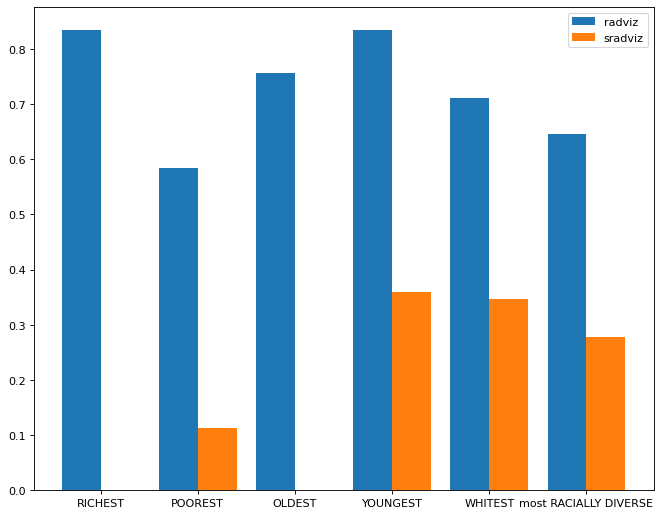

In [96]:
# Define Data
quest = list(map(lambda x: x["q"], questions))
x_axis = np.arange(len(quest))
offset = -0.2

# Add size
plt.figure(figsize=(10, 8), dpi=80)

for state in metadata.keys():
    responses = pd.read_csv(metadata[state]["responces"])
    df = pd.read_json(metadata[state]['point_coordinates'])
    county_to_index_map = lambda county_name: df['textFloater'].to_list().index(county_name)
    coordinates = json.loads(json.dumps(df["coordinates"].tolist()))
    x = list(map(lambda x: x["x"], coordinates))
    y = list(map(lambda x: x["y"], coordinates))
    data = np.array([x, y])
    
    # Constructing distance_matrix
    construct_distance_matrix(state, data)
    
    g_data = apply_func(responses, get_distance, state)[list(map(lambda x: x["q"], questions))].mean(axis=0).values
    
    # Multi bar Chart
    plt.bar(x_axis + offset, g_data, width=0.4, label = metadata[state]['graph'])
    offset += 0.4
    
# Xticks
lebels = []
for q in quest:
    start = 9
    end = q.index("(") - len("county  ")
    lebels.append(q[start:end])
plt.xticks(x_axis, lebels)

# Add legend
plt.legend()

# Display
plt.show()

In [50]:
def get_distance(selected, target, distance_matrix):
    selected_index = county_to_index_map(selected)
    target_index = county_to_index_map(target)
    
    return distance_matrix[selected_index][target_index]

In [71]:
def get_cached_distance_matrix(state):
    if not cached_distance_matrix[state]:
        raise Exception("distance_matrix has not been constructed.")
        
    return cached_distance_matrix[state]

In [94]:
def construct_distance_matrix(state, data):
    cached_distance_matrix[state] = distance_matrix(data, euclidian_distance)

In [73]:
def apply_func(df, func, state):
    res = df.copy(deep=True)
    for q in questions:
        ques = q["q"]
        distance_matrix = get_cached_distance_matrix(state)
        base = get_cached_df(state, q['attr'])
        
        if q["target"] == "max":
            target = base.tail(1).values[0][0]
        elif q["target"] == "min":
            target = base.head(1).values[0][0]
        res[ques] = df[ques].apply(lambda selected: func(selected, target, distance_matrix))
    return res

In [75]:
def get_cached_df(state, attr):
    if attr not in cached_state_attribute_df[state].keys():
        df = pd.read_json(metadata[state]["state_data"])
        cached_state_attribute_df[state][attr] = create_sorted_attribute_df(df, attr)
        
    return cached_state_attribute_df[state][attr]

In [80]:
def create_sorted_attribute_df(original_df, attribute):
    return original_df.sort_values(attribute, ignore_index=True)[["county_name", attribute]]